## Spark Architecture

#### Spark Cluster Runtime Architecture

**Cluster** : Pool of computers working together but viewed as a single system
- Example Cluster config
    - Worker Node Capacity
        - 16 CPU Cores
        - 64 GB RAM
    - Cluster Capacity
        - 160 CPU Cores
        - 640 GB RAM

- will use the spark-submit command and submit my spark application to the cluster
- Request will go to the YARN/Kubernetes/Mesos resource manager.
- YARN RM wil create one *Application Master container* on a worker node and start my application's main() method in the container, here container is an isolated virtual runtime environment. Comes with some CPU and memory allocation.
Example- let's assume YARN RM gave 4 CPU Cores and 16GB memory to this container and started it on a worker node, where this worker node has total 16CPU cores and 64GB of memory.
- Application Master Container - The container is running the main() method of my application either in Python or Scala. But Spark is written in Scala, and it runs in the Java virtual machine. Scala is a JVM language, and it always runs in the JVM. So they created a Java wrapper on top of the Scala code. And then they crated a Python wrapper on top of the Java wrappers, and this Python wrapper is known as PySpark.
- So here we have Python code in my main() method. This python code is designed to start a Java main() method internally. So PySpark application will start a JVM application. Once we have the JVM application, the PySpark wrapper will call the Java Wrapper using the Py4J connection. Py4J allows a Python application to call a Java application. It will always start a JVM application and call Spark APIs in the JVM. The actual Spark application is always a Scala application running in the JVM, BUT PySpark is calling Java Wrapper using Py4J, and Java Wrapper runs Scala code in the JVM.
- PySpark main method is my PySpark Driver and JVM application here is my Application Driver, Spark application driver is the main method of our application. So for PySpark we would have PySpark Driver + Application Driver, for Scala we will have only Application Driver.
- Spark application is a distributed application in itself, means application driver distributes the work to others. Driver doesn't perform any data processing work, instead it will create some executors and get the work done from them. After starting, the driver will go back to the YARN RM and ask for some more containers.
- RM will create some more containers on worker nodes and give them to the driver. 
Ex: assume we got 4 new containers, each comes with 4 CPU Cores and 16 GB of memory, now the driver will start spark executor in these containers. Each container will run one SPARK executor, and the Spark executor is a JVM application. So driver is a JVM application and executor is also a JVM application. These executors are responsible for doing all the data processing work. The driver will assign work to the executors and monitor them, and manage the overall application, but the exectors do all the data processing.
- Application Master Container[[PySpark Driver + JVM/Application Driver]] -> cluster RM[YARN] -> Workers[JVM executors, Python Worker]  
if using some additional Python libraries that are not part of the PySpark, ex- UDFs
- Python worker is a Python runtime environment, and need them only if using some python specific code or libraries. PySpark is python wrapper on java code. So as long as we using only PySpark, do not need Python Runtime environment, All the PySpark code is translated into Java code, and it runs in the JVM. Executors will create a Python Runtime Environment so they can execute our Python Code.

#### Spark Submit and Important Options

**Spark Submit** : A command line tool that allows to submit the Spark application to the cluster
ex- 
    - spark-submit --class <main class> --master <master-url> --deploy-mode <deploy-mode> <application-jar/pyspark script> 
    [application-args]  
    - spark-submit --master yarn --deploy-mode cluster --driver-cores 2 --driver-memory 8G --num-executors 4 --executor-cores 4 --executor-memory 16G hello-spark.py  
    - spark-submit --class myclass.something.HelloSpark --master yarn --deploy-mode cluster --driver-cores 2 --driver-memory 8G --num-executors 4 --executor-cores 4 --executor-memory 16G hello-spark.jar  
- --class : Not applicable for PySpark
- --master : YARN, local[3]
- --deploy-mode : client/cluster
- --conf : spark.executor.memoryOverhead = 0.20
- --driver-cores : 2
- --driver-memory : 8G
- --num-executors : 4
- --executor-cores : 4
- --executor memory : 16G



#### Deploy Modes - Client/Cluster mode

- Cluster Mode : Driver runs in the cluster, allows to submit the application and log off from the client machine, coz the driver & executors are running on the cluster, nothing active on client's machine. Runs faster coz driver is closer to executors.
    - No dependency on client machine
    - Performance
- Client Mode : Driver runs in client machine, when driver is local, can easily communicate with the driver and show it back to us.
    - spark-shell, pyspark, spark-sql : gives interacive method to work with Spark, run the code and show us the results
    - Notebooks

#### Spark Jobs - Stage, Shuffle, Task, Slots

**Spark Data Frame API Categores**
- Transformations
    - Used for transforming data
    - Furhter classification
        - Narrow dependency
            - peformed in parallel on data partitions
            - ex- select(), filter(), withColumn(), drop()
        - Wide dependency
            - Pefrormed after grouping data from multiple partitions
            - ex- groupBy(), join(), cube(), rollup() and agg(), repartition()
- Actions 
    - Used to trigger some work(Job)
    - Example: read(), write(), collect(), take() and count()
    - All spark actions trigger one/more Spark jobs.

- Spark will run each code block as one spark job in other words each spark action runs as a spark job that contains all the transformations of its code block, so we will look for actions to separate spark code blocks
- BLOCK(Decide by each action occurred) :: 0 : (Read Action) 
`surveyRawDF = spark.read.option("header", "true).option("inferSchema", "true").cav(args(0))` 

- BLOCK(Decide by each action occurred) :: 1 : (Collect Action) 
    - ###### Wide Transformation 1 : reparition
    `patitioinedSurveyDF = surveyRawDF.repartition(numParitions=2)`  
    - ###### 2(narrow transformation-Where), 3(narrow transformation - Select), 4(Wide Transformation-groupBy), 5(narrow trans-count)
    `countDF = patitioinedSurveyDF.where("Age < 40").select(col="Age:, cols="Gender","Country","state").groupBy("Country").count()`  
    - ###### ACTION - collect()
    `logger.info(countDF.collect().mkString("->"))`  

- **BLOCK 1** : let's consider this block 
    - Application Driver will take this block, compile it and create a Spark Job. But this job will be performed by the executors, coz the Driver doesn't perform any data processing job. Driver will break this job into smaller tasks and assign them to executors.
    - Driver will create a *logical query plan* for each spark job.
    - Job 2(coz job1 is to read csv above) : will start with surveyDF and repartition it to create partitionedSurveyDF and then apply 4 transformations to create the countDF  
    *Logical Plan* :: surveyDF -> REPARTITION(yields partitionedSurveyDF) -> [ WHERE -> SELECT -> GROUP BY -> COUNT(yields countDF) ]
    - Once we have the logical plan, the driver will start breaking this plan into stages. Driver will look at this plan to find out the WIDE Transformations. Here we have 2 Wide transformation(repartition() & groupBy() method) in CODE BLOCK 1. So the driver will break this plan after each wide transformation, and our logical plan broken down into 3 stages, each stage can have one/more narrow transformations and the last operation of the stage is a WIDE transformation. 
        - STAGE 1 :: REPARTITION
        - STAGE 2 :: [WHERE, SELECT, GROUPBY]
        - STAGE 3 :: COUNT
    - Spark can't run these stages in parallel, it should finish the 1st stage, and then only can start the next stage coz the output of the first stge is an input for the next stage

        - STAGE 2 :: [WHERE, SELECT, GROUPBY]
        - STAGE 3 :: COUNT

**STAGE 1** :: REPARTITION : read surveyDF and repartition it to create partitionedSurveyDF(2 partition). The final output of the stage must be stored in an *exchange buffer(WRITE EXCHANGE here)*. Output of this stage becomes the input of the next stage, so the next stage starts with an *exchange buffer(READ EXCHANGE here)*. Spark is a distributed system so both exchange may be on 2 diff/same worker nodes. So we must consider a copy of data partitions from the WRITE Exchange to Read Exchange, and this copy operation is popularly known as the Shuffle/Sort operation. Where Shuffle/Sort is not a plain copy of data, a lot of things happens here. So bascially Shuffle/Sort will move data from the WRITE Exchagne to Read Exchange. Notice stage ends with a WIDE Transformation, and hence it requires a Shuffle/Sort of the data, which is an expensive operation in the Spark Cluster and it requires a Write Exchange Buffer and a Read Exchange Buffer. The data from Write Exchange Buffer is sent to the Read Exchange Buffer over the network.

TASK1[REPARITION(2)] ====> |Write Exchange(stage 1| 

**STAGE 2** :: [WHERE, SELECT, GROUPBY] : Read Exchange has got 2 partitions coz of above repartition(2) operation and also configured spark shuffle partitions to ensure we preserve those 2 partitions in the Read Exchange. So we have 2 input partitions here and can run these transformations in parallel on those 2 partitions, here we have 2 parallel tasks in this stage. This stage also ends with a Wide Transformation, again we need a Shuffle/Sort operation here  

-------------- ====>partition 1 -> TASK1[WHERE, SELECT, GROUPBY] >  
|Read Exchange from stage1 input|-----------------------------------------------------|Write Exchange(stage 2)|  
-------------- ====>partition 2 -> TASK2[WHERE, SELECT, GROUPBY] >  

**STAGE 3** :: COUNT : Assume 2 partitions in Stage 2's Write Exchange, so this stage's task can also run in parallel

-------------- ====>partition 1 -> TASK1[COUNT] >  
|Read Exchange from stage 2 input|  
-------------- ====>partition 2 -> TASK2[COUNT] >  

Summary:
- Job : Spark creates 1 job for each action, may contain a series of multiple transformations. Spark engine will optimize those transformations and create a logical plan for the job.
- Stage : Spark will break the logical plan at the end of every Wide Transformation and create 2/more stages. If no wide trans plan will be a single-stage plan, but if have N Wide Transformations, plan should have N+1 stages.
- Shuffle/Sort : Data from one stage to another stage is shared using the shuffle/sort operation.
- Task : Each stage may be executed as one or more parallel tasks. Task is a smallest unit of work in a Spark job. Spark Driver assigns these tasks to the executors and asks them to do the work. Executor needs the Task Code & Data Partitions to perform the task. Driver is responsible for assigning a task to the executor. Executor will ask for the code/API to be executed for the task, and also DF partition on which to execute the given code. The application driver facilitates both these things to the executor, and the executor performs the task.

How Above plan will fit into the cluster?  
Consider we have a driver and 4 executors(on 4 worker nodes), each executor will have one JVM process. But we assigned 4 CPU Cores to each executor with 16GB memory, so my Executor-JVM can create 4 parallel threads on each worker node and that's the ***SLOT*** capacity of my executor. So each executor can have 4 parallel threads, and we call them executor slots. The driver knows how many slots do we have at each executor, and it is going to assign tasks to fit in the executor slots.

client Machine(spark-submit cluster Mode) -> YARN RM -> Driver JVM -[4 Workers with thier own Executor-JVM(each with 4 slots)]

Collect() Action : requires each task to send data back to driver. So the tasks of the last stage will send the result back to the driver over the network. The driver will collect data from all the tasks and present it to you. If we have an action to write the result in a data file, in that case all the tasks will write a data file partition and send the partition details to the driver. Driver considers the job done when all the tasks are successful. If any tasks fails, the driver might want to retry it. It can restart the task at a diff executor. If all retries also fail, then the driver returns an exception and marks the job failed.

#### Spark SQL Engine and Query Planning

<img src="/workspaces/Atlas/AtlasCodeLearn/ASonD/images/query_planning.png">

- Unresolved Logical Plan : in-case of DataFrame API code, spark will take action and all it's preceding transformations to consider it a single job. Similarly if have a SQL expression, Spark considers 1 SQL expression as one Job. Each job represents a *logical query plan*. This 1st logical plan is a user-created logical plan.
- Spark SQL Engine : unresolved logical plan goes to Spark SQL Engine whether DF API/SQL. For spark they are nothing but a Spark Job represented as a logical plan. Spark SQL Engine will process logical plan in 4 stages  
Ex- SELECT prod_qty + 5 FROM sales
    - Analysis : parse code for errors and incorrect names using catalog, might apply an implicit casting to the 'prod_qty' to perform and validate the addition operation. So analysis phase will parse code and create a fully resolved plan.
    - Logical Optimization : Applies standard rule-based optimizations to the logical plan. Ex-
        - Constant folding
        - Predicate pushdown
        - Partition pruning
        - Null propagation
        - Boolean expression simplification
    - Physical Planning(Physical plans + cost model + selected physical plan) : Takes a logical plan and generates one/more physical plans in this phase. Physcial planning applies cost-based optimization, calculate each plan's cost and finally select the plan with the least cost. At this stage, mostly use diff join algorithms to create more than one physcial plan. For ex they might create 1st plan using Broadcast join and another using Sort merge and more using shuffle hash join. Then apply a cost to each plan and choose the best one.
    - Code Generation : Best physical plan goes into code generation, and engine will generate Java byte code for the RDD operations in the physical plan. And that's why Spark is also said to act as a compiler, coz it uses start of the art compiler technology for code generation to speed up execution.


## Performance and Applied Understanding

#### Spark Memory Allocation

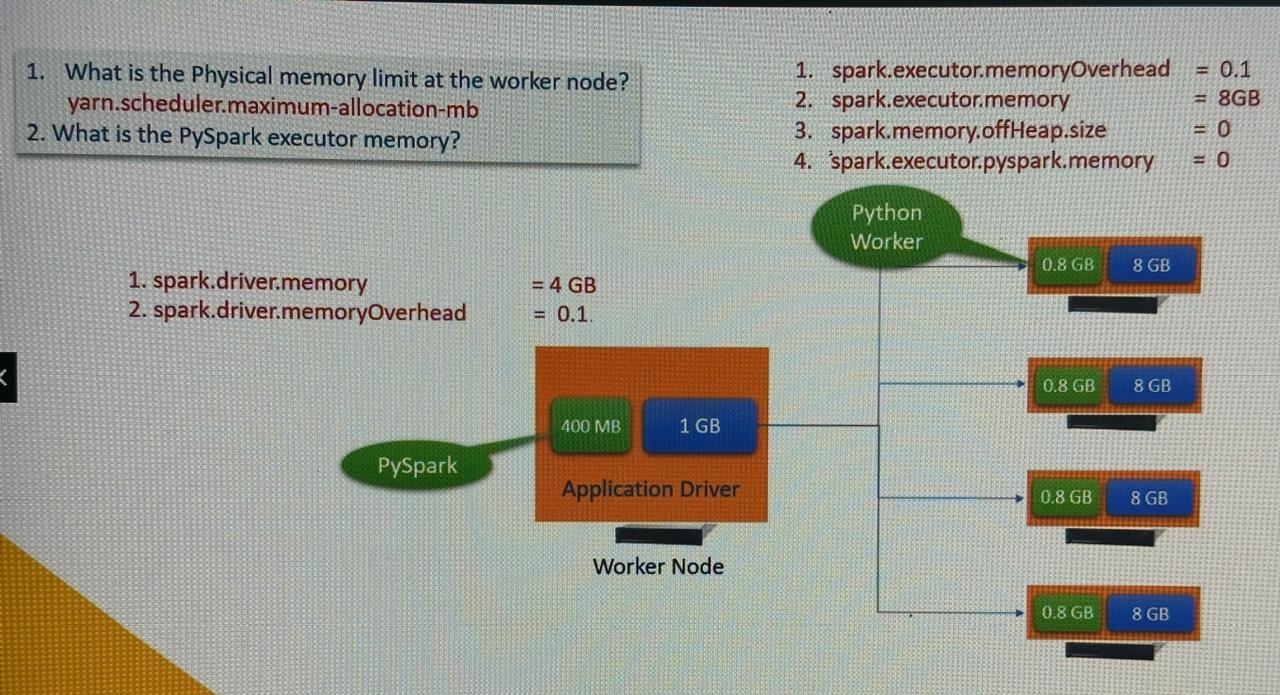

In [2]:
from IPython.display import Image
Image("/workspaces/Atlas/AtlasCodeLearn/ASonD/images/SparkMemoryAllocation.jpeg")

***Driver Memory Allocation***
Let's consider we submitted a spark application in a YARN cluster. YARN RN will allocate an Application Master Container and start the driver JVM in the container. The driver will start with some memory allocation which requested.
- We an ask for the driver memory using two configuration
    - `spark.driver.memory = 1GB`  -> JVM Memory : YARN RM will allocate 1GB of memory for the driver JVM. Spark driver uses all the this JVM Heap but nothing from below overhead's/384MB.
    - `spark.driver.memoryOverhead = 0.1(Default)`  -> MAX(10% or 384MB) : Allocate 10% of above requested memory or 384MB, whichever is higher for container overhead. As we asked for 1GB so 10% of it will be 100MB, but 384MB(Default is higher), so it will allocate 384MB for overhead. The overhead memory is used by the container process or any other non-JVM process within the container.
    - So in our case total memory of Application Master Container is = 1GB + 384MB
- For our case let's consider `spark.driver.memory = 4GB` Heap Memory & `spark.driver.memoryOverhead = 0.1(Default)`=400MB coz 400 > 384 overhead memory for Driver requested.
    - Spark driver JVM can't use more than 4GB
    - non-JVM workload in the container can't use more than 400MB.
    - And Application Master Container can't use more than 4.4GB of memory in total. If any of these limits are violated, we will see an <font color='red'>*OOM exception*</font>.

***Executor Memory Allocation***
Now the *Driver* started with 1GB of JVM Heap, so the driver will again request for the executor containers from the YARN. YARN RM will allocate a bunch of executor containers. So a Spark driver will ask for executor container memory using 4 configuration, total memory Allocated to the executor container is the sum of the following conig:
- Here Total we will get 8GB JVM Heap Memory requested + (8GB*10%=800MB) OverheadMemory + 0+ 0 => 8.8GB each executor container will get : Driver will ask for 8.8GB containers to the YARN RM. But if each worker has only 6GB then it's can't provide 8.8GB, in such cases when YARN RM is used can check 2 properties - `yarn.scheduler.maximum-allocation-mb` & `yarn.nodemanager.resource.memory-mb`
Ex- InstanceType=c4.large(3.75GB RAM), `yarn.scheduler.maximum-allocation-mb=1792MB`, EMR cluster will start with the default value of 1792MB, meaning we can't ask for a container of higher than 1.792GB.
    - **Overhead Memory** :: `spark.executor.memoryOverhead = 0.1` (Default), will be using overhead memory as shuffle exchange or reading partition data from remote storage etc. Lack of enough overhead memory will cost an <font color='red'>*OOM exception*</font>. Overhead memory is often overlooked, but it is used as shuffle exchange/netowrk read buffer.
    - **Head Memory/JVM Heap** :: `spark.executor.memory = 8GB`(Requested)
    - **Off Heap Memory** :: `spark.memory.offHeap.size` = 0(Default)
    - **PySpark Memory** :: `spark.executor.pyspark.memory` = 0(Default)

- What is the Physical memory limit at the worker node? : `yarn.scheduler.maximum-allocation-mb`
- What is the PySpark executor memory? : We don't need to worry about PySpark memory if we write Spark Application in Java/Scala. PySpark is not a JVM Process, so we won't get anyting from those 8GBs. All we have is 800MB of overhead memory. Some 300-400MB of this is constantly consumed by the container processes and other internal processes. So PySpark will get approximately 400MB. *iF pYsPARK consumes more than what can be accommodated in the overhead, we will see an <font color='red'>OOM error</font>*
- From YARN perspective, we have a container and the container has got some memory.
[Heap Memory[JVM Process], Overhead/OS Memory[non-JVM Process]] =>we call it Driver Memory when running a Driver in this container, similarly executor memory when the container is running an executor.

#### Spark Memory Management

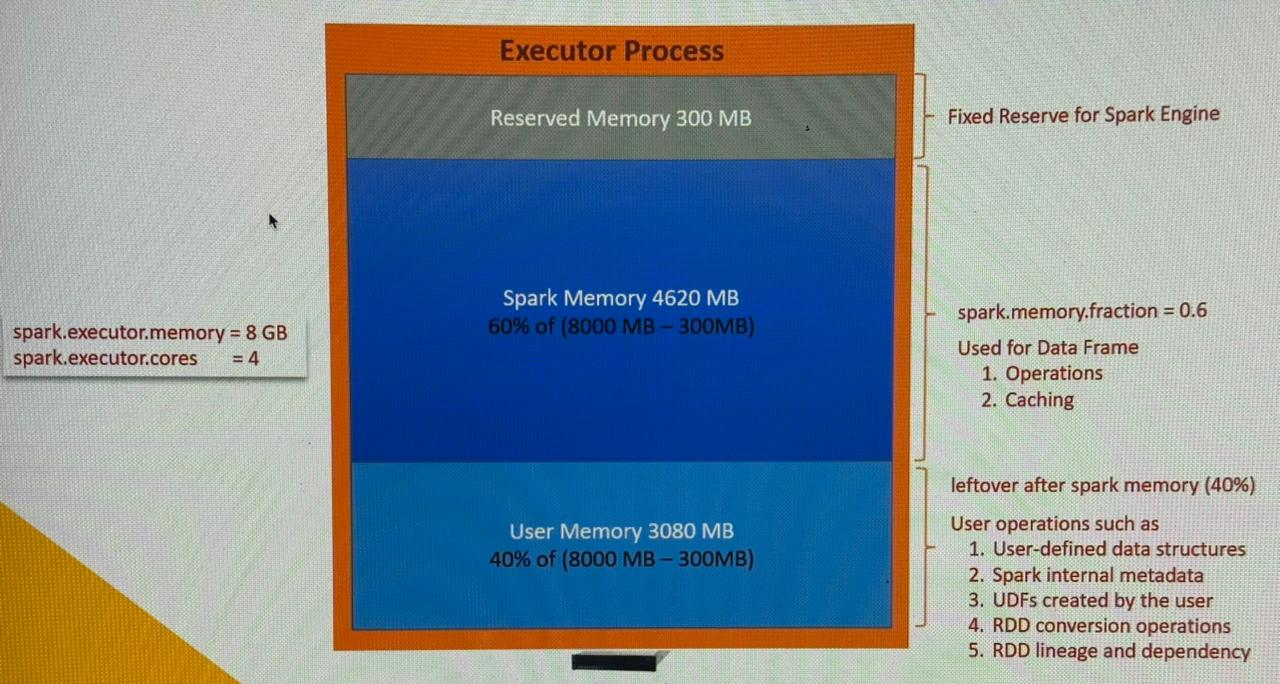

In [1]:
from IPython.display import Image
Image("/workspaces/Atlas/AtlasCodeLearn/ASonD/images/executor_process.jpeg")

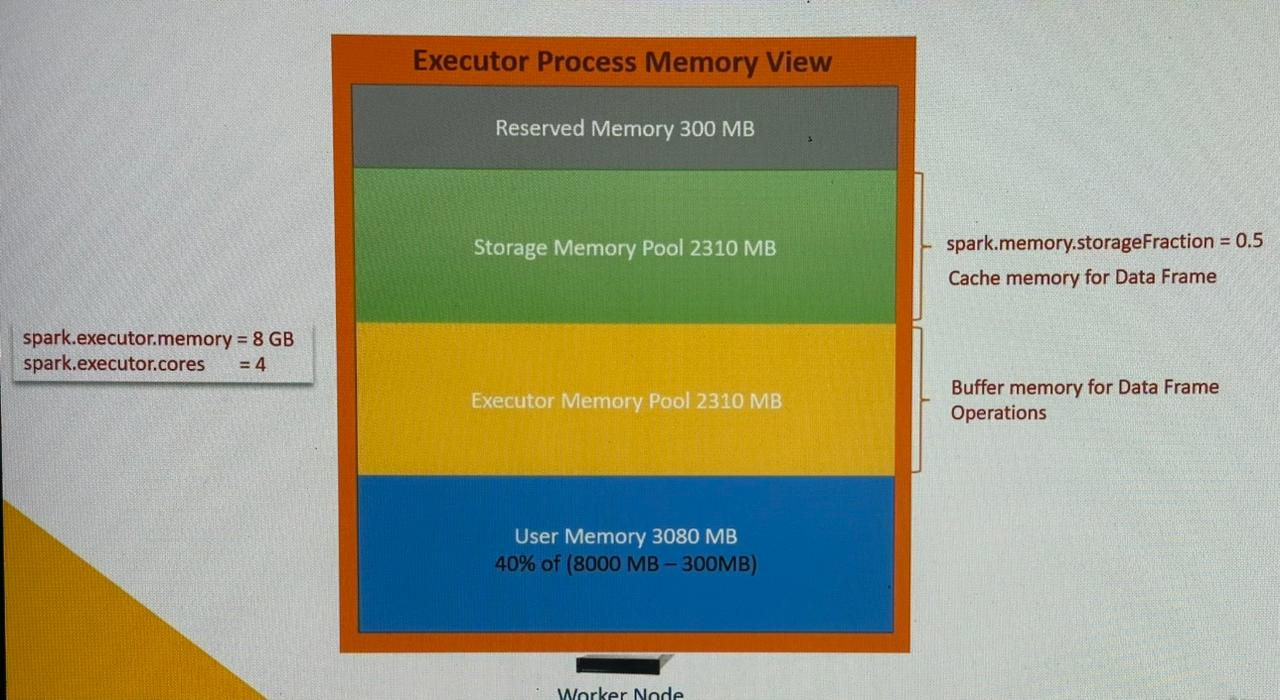

In [2]:
from IPython.display import Image
Image("/workspaces/Atlas/AtlasCodeLearn/ASonD/images/executor_process_memory_view.jpeg")

***How Spark utilizes JVM Heap memory?***
in our case :: `spark.executor.memory=8G`

**Executor Process Memory View**:
- HEAP Memory is further broken down into 3 parts : 
    - Reserved Memory 300MB + : Fixed Reserve for Spark Engine
    - Spark Executor Memory Pool 4620MB(60% of 8000MB-300MB) + : controlled by the config `spark.memory.fraction=0.6` with default value 60%.
    - User Memory Pool 3080MB(40% of 8000MB-300MB)

    - **Reserved Memory Pool 300MB**: Reserved pool is gone for the Spark engine itself, we can't use it. 
    - **Spark Memory pool 4620MB**:  is main executor memory pool where all our DFs and DF's operations live, so use for 
        - data frame operations : if using DF operations, they don't use the user memory even if the DF is internally translated and compiled into RDD.
        - caching.
        - can increase it from 60% to 70%, or even more if not using UDFs, custom data structure and RDD operations.
        - This memory pool is further broken down into 2 sub-pools with default breakup of 50% each
            - <font color='Blue'><u>Storage Memory Pool 2310 MB(long-term)</u></font>: `spark.memory.storageFraction=0.5`(default), can be changed. 
                - We use storage pool for caching data frames.
                - So if using cache operation, will be caching the data in the storage pool, as long as the executor is running or want to un-cache it.
            - <font color='Blue'><u>Executor Memory Pool 2310 MB(short-term)</u></font>: Executor pool is to perform dataframe computations. 
                - if joining 2 data frames, Spark will need to buffer some data for performing the joins. That buffer is created in the executor pool.
                - if aggregating/peforming some calculation, required buffer memory comes from the executor pool.
                - so executor pool is short-lived, wil use it for execution and free it immediately as soon as execution is complete.
    - **User Memory pool 3080MB**: can't make it 0 or reduce it too much coz we will need it for metadata and other internal things. Used for non-dataframe operations,
        - User-defined data structures (HashMap)
        - Spark internal metadata
        - UDFs created by the user
        - RDD conversion operations : only if we apply RDD operations directly in our code.
        - RDD lineage and dependency


**Executor Compute View** : `spark.executor.cores=4`

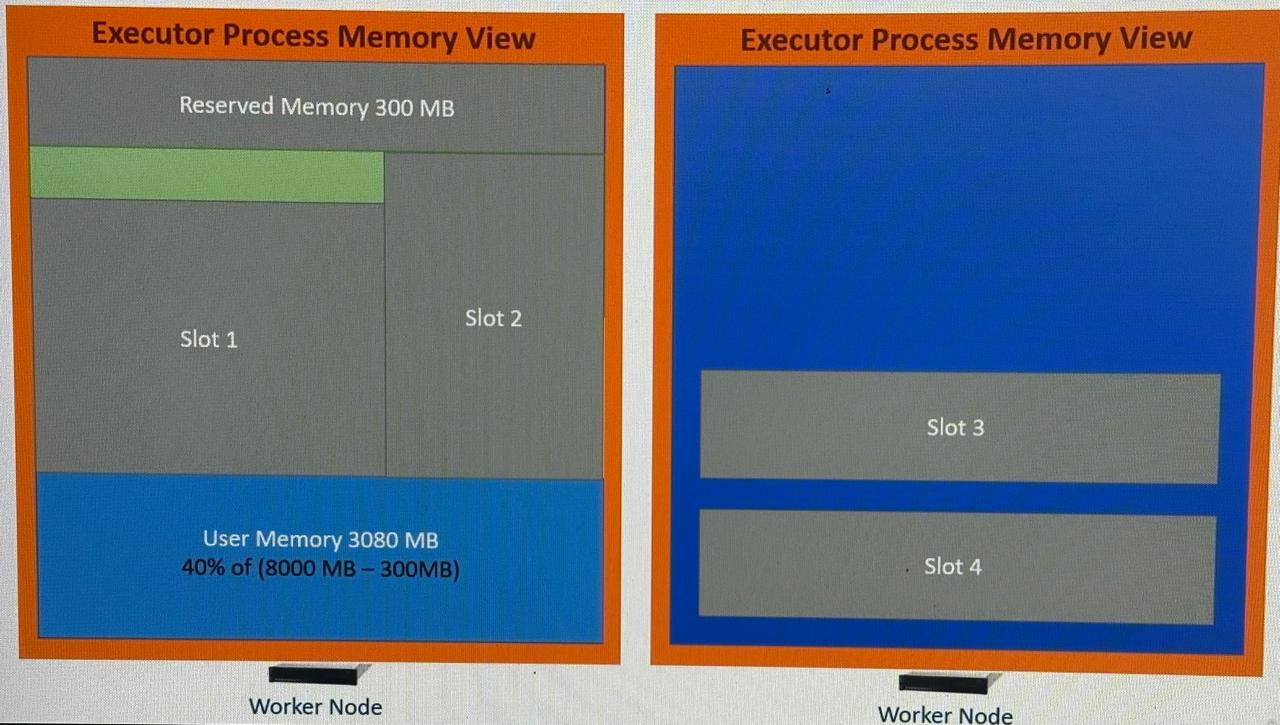

In [5]:
from IPython.display import Image
Image("/workspaces/Atlas/AtlasCodeLearn/ASonD/images/unified_memory_mgr_v1.jpeg")



Executor will have 4 slots, and can run 4 parallel task in these slots. Slots are threads.All these slots are threads within the same JVM. We have a single JVM, and all the slots are simply threads in the same JVM. So we have 1 executor JVM, 2310MB storage pool and another 2310MB executor pool. And 4 threads to share these 2 memory pools.

How much executor memory will each task get from 2310MB executor pool? 
- Static Memory Management : 2310/4, Spark used to assign task memory using this static method before spark 1.6.
- Unified Memory Manager : 
    - Tries to implement fair allocation amongs the active tasks. consider we have 4 slots, but only 2 active tasks are there, so it can allocate all between 2 active slots 2310/2 or depending on load on both slots could be 6:4, 7:3, 2:8 any ratio. 
    - Nothing reserve for any task, task will demand the execution memory and the unified memory manager will allocate it from the pool. 
    - If the executor memory is fully consumed, can also allocate executor memory from storage memory pool as long as we have some free space there.
    - We start with 50-50 boundary between executor memory and storage memory. But can be changed using "spark.memory.storageFraction". If we don't cache too many data frames, can reduce it to 30%, but this boundry is flexible and can still borrow space from this 30% as long as free space there. So the memory manager can borrow some memory from the other side as long as the other side is free.
    - Case : 
        - we cached some DFs and entirely consumed the storage memory pool, but want to cache some more data. So memory manager will give some more memory from the executor memory pool if free space is there.
        - Now executor is performing some JOIN operation and it needs memory, so the executor will start consuming memory as long as there is free space in executor memory pool. But in the end if more required, memory manager will evict the above cached data frame occupying executor memory pool shifted here coz of additional space requirement after consuming storage memory fully, and spill them to the disk to make more sapce for the executor. However we reached the boundary of executor memory pool, and need more memory for computation, this boundary is rigid , and the memory manager can't evict any cached data blocks in storage memory pool. if it was free it would have given it to the executor. But it is not free and we already occupied using cached blocks. Now executor will try to spill few things to the disk and make some more room for itself, but if have things that can't spill to disk then hitting the <font color='Red'>OOM Exception</font>
        - So basically it will respect the defind boundary but if free space there can try to accomodate between both, else not.
        - In summary we have the following configurations to control it:
            - `spark.executor.memoryOverhead` : 10% extra of whatever asking for JVM for non-JVM processes, it is outside JVM and reserved for overhead.
            - `spark.executor.memory` : JVM memory comes from here, whatever we get spark will reserve 300MB from it
            - `spark.memory.fraction` : to tell how much we want to use for DF operations, Default 60% but can increase/decrease it. Leftover is kept aside for non-dataframe operations and we call it user memory. 
            - `spark.memory.storageFraction` : Allows to set a hard boundary that the memory mgr can't evict. if not using cached data, can reduce this hard limit.
            - `spark.executor.cores` : can ask for cores per executor, critical coz this config defines the max number of concurrent threads. Too many threads, will have too many tasks competing for memory, if single thread might not be able to use the memory efficiently.
            - Below 3 will give off-head memory outside JVM. Most operations & data caching are performed in the JVM heap. And they perform best using the on-heap memory. However JVM Heap is subject to GC. So if allocating a huge amount of heap memory to executor, might see excessive garbage collection delays. However Spark 3.x optimized to perform some operations in the off-heap memory. Using off-heap memory gives the flexibility of managing memory by yourself and avoid GC delays. Spark can take some advantage of this idea and use off-heap memory. So if we need an excessive amount of memory for Spark application, it might help to take some off-heap memory. For large memory requirements, mising some on-heap and off-heap might help to reduce GC delays. By default the off-heap memory feature is disabled.  Spark will use the off-heap memory to extend the size of spark executor memory & storage memory pool. So adding off-heap is an indirect method of incrasing the executor & storage memory pools.
            - `spark.memory.offHeap.enabled` : can eable off-heap memory feature by setting it to true.
            - `spark.memory.offHeap.size` : can set off-heap memory requirement using spark.memory.offHeap.size
            - `spark.executor.pyspark.memory` : Spark is JVM Application, but if using PySpark, applicatioin may need a Python worker. These python workers can't use JVM Heap memory, so they use off-heap overhead memory. IF need more off-heap overhead memory for python workers, then can set extra memory requirement using this property. This property doesn't have default value. coz most of the PySpark appliations don't use external Python libraries, and they don't need python worker.

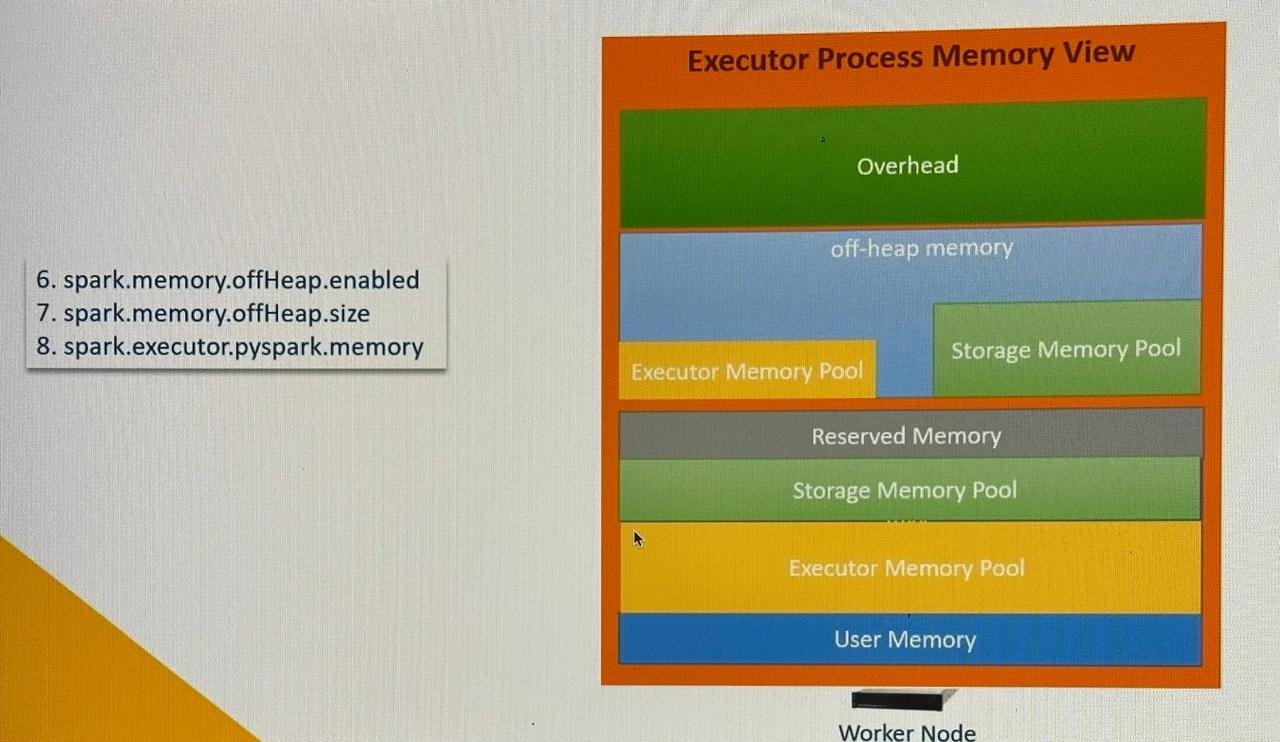

In [1]:
from IPython.display import Image
Image("/workspaces/Atlas/AtlasCodeLearn/ASonD/images/executor_process_memory_view_with_heap.jpeg")

#### Spark Adaptive Query Execution
Adaptive Query Execution (AQE) is an optimization technique in Spark SQL that makes use of the runtime statistics to choose the most efficient query execution plan, which is enabled by default since Apache Spark 3.2.0. Spark SQL can turn on and off AQE by spark.sql.adaptive.enabled as an umbrella configuration. As of Spark 3.0, there are three major features in AQE:   
    - including coalescing post-shuffle partitions/ Dynamically coalescing shuffle partitions  
    - converting sort-merge join to broadcast join/ Dynamically switching join strategies  
    - and skew join optimization/ Dynamically optimizing skew joins  

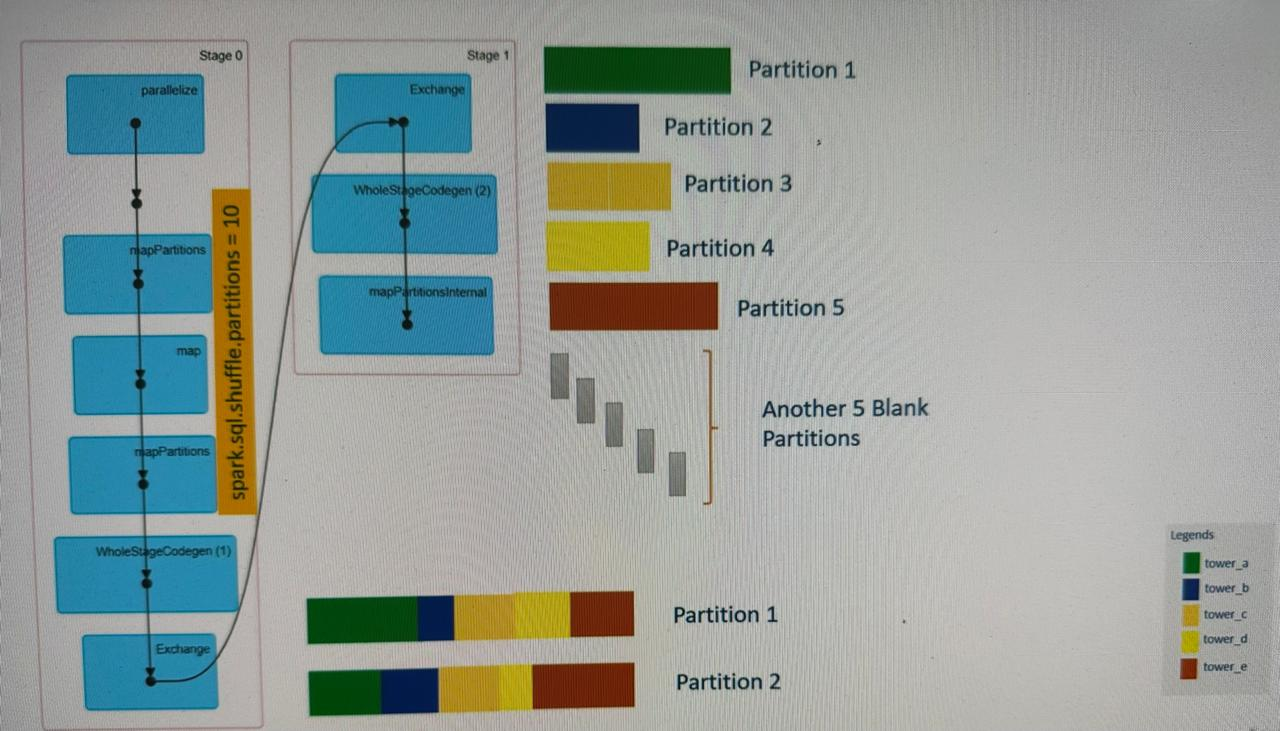

In [4]:
from IPython.display import Image
Image("/workspaces/Atlas/AtlasCodeLearn/ASonD/images/AQE_sample_query_stages.jpeg")

##### Dynamically Coalescing shuffle partitions.

**Problems** : how AQE solves these problems?  
Assume we are running-  
`SELECT tower_location, sum(call_duration) as duration_served FROM call_records GROUP BY tower_location`  
OR  
`df.groupBy("tower_location").agg(sum("call_duration")).alias("duration_served")`

The spark job that triggers this query should have a 2-stage plan as above. The actual plan for the large volume of data might now look the same. However we will have 2 stages.
- Stage 0: Reads the data from the source table and fills it to the output exchnage. 
- Stage 1 : will read the data from the output exchange and brings it to the input exchange, and this process is known as shuffle/sort.     
    - Because we are doing groupBy wide-dependency operation, that's why we have shuffle/sort.
    - Stage 1 is dependent on stage 0, so stage 1 can't start unless stage 0 is complete.

**Stage 0 : Output Exchange** 
consider we have 2 partitions and total unique towers are - tower_a, tower_b, tower_c, tower_d, tower_e. The output exchange might look like as -  
- PARTITION 1 ::[(tower_name, volume% data)] : [(tower_a,40%), (tower_b,10%), (tower_c,15%), (tower_d,15%), (tower_e,20%)]  
- PARTITION 2 ::[(tower_name, volume% data)] : [(tower_a,20%), (tower_b,20%), (tower_c,10%), (tower_d,5%), (tower_e,45%)]  


**Stage 1 : Input Exchagne**
coz only 2 partitions in input source, so this  exchange shows only 2 partitions.
- Now the shuffle/sort operation will read these partitions, sort them by the tower_locatoin and bring them to the input exchange of stage 1.
- Now final result in input exchange might look like with config `spark.sql.shuffle.partitions=10` (default is 200, but we don't have 200 unique towers so manually override it with 10)
    - Shuffle/Sort will create 10 partitions in the exchange, even though if we have only 5 unique values. 5 of them will have data and rest with blank partitions. So we need here <u>10 tasks, coz we have 10 partitions in the input exchange, which is a problem</u>. 5 partitions are empty, but Spark will still trigger 10 tasks. The empty partition task will do nothing and finish in milliseconds. But spark scheduler needs to spend time scheduling and monitoring these useless tasks. This overhead is small, but we do have some unnecessary overhead here.
        - PARTITION 1 :: [(tower_name, volume)] : (tower_a, 60)
        - PARTITION 2 :: [(tower_name, volume)] : (tower_b, 30)
        - PARTITION 3 :: [(tower_name, volume)] : (tower_c, 25)
        - PARTITION 4 :: [(tower_name, volume)] : (tower_d, 20)
        - PARTITION 5 :: [(tower_name, volume)] : (tower_e, 65)  
        - PARTITION 6 :: [(tower_name, volume)] : NULL
        - PARTITION 7 :: [(tower_name, volume)] : NULL
        - PARTITION 8 :: [(tower_name, volume)] : NULL
        - PARTITION 9 :: [(tower_name, volume)] : NULL
        - PARTITION 10 ::  [(tower_name, volume)] : NULL
    - However we set shuffle partition to 10 from default 200, but it's not an easy coz we can't keep changing the shuffle partitions for every query. Even if we want to do that, we don't know how many unique values my SQL will fetch. The numer of unique keys are dynamic and depends on the dataset.
    - Some partitions are big and others are small: so a task working on partition 5 will take longer time, while task doing the partiton 4 will finish very quickly. it is not good coz the stage is not complete until all the tasks of the stage are complete. 3 task processing partition 2,3,4 will finish quickly, but still need to wait for partition 1 & 5, which is a wastage of CPU resources. This situation becomes worse when one partition becomes excessively long and it represents a <font color="Red">**DATA SKEW**</font> problem
    - So our query resulted in 5 disproportionate shuffle partitions. We made an intelligent guess and decided to reduce it to 10. However it's not enough.

**Solution** : How we are supposed to know how many shuffle partitions do we need?
Spark 3.0 offers <u>Adaptive Query Execution to solve this problem</u>. We must enable it and AQE will take care of setting the number of shuffle partitions. But how it happens?
- coz input data is already loaded in stage 0's output exchange. Now spark will start the shuffle/sort, so it can compute the statistics on this data and find out some details such as the following, and this is called dynamically computing the statistics on data during shuffle/sort. Such dynamic statistics are accurate and most up-to-date. When spark knows enough about the data , will dynamically adjust the number of shuffle paritions for the next stage.
    - Number of unique tower_location = 5
    - Number of records in tower_locations
        - tower_a/Partition 1 = 120K
        - tower_b/Partition 2 = 70K
        - tower_c/Partition 3 = 50K
        - tower_d/Partition 4 = 40K
        - tower_e/Partition 5 = 130K      
    - Spark might dynamically set the shuffle partitions to 4 in our case, and it may look like
        - tower_a/Partition 1 = 120K
        - tower_b/Partition = 70K
        - tower_c+tower_d/Partition 3 = 90K
        - tower_e/Partition = 130K  
- So we have 4 shuffle partitions for Stage 1, and those 5 empty partitions are gone. Spark merged 2 small partitions to crate one larger partition. So instead 5 disproportionate partitions we have 4 partitions, and these are little more proportionate. Now we need only 4 tasks to execute in this stage. Task 2 will finish quicly but other 3 tasks will take around equal time.
- So we saved 1 CPU slot and we also eliminated useless empty tasks.

**Summary**
- Shuffle/Sort has a critical impact on Spark query performance.
- One fundamental tunig property of shuffle operation is the number of output partitions. We can set this number using spark.sql.shuffle.partitions.
- Tuning spark.sql.shuffle.partitons is complex for following reasons
    - Small number of partitions casue
        - Large partition size
        - Task need large amount of memory
        - May cause OOM exception
    - Large number of partitions casue
        - Small/tiny partition size
        - Many network fetch causing inefficient network I/O
        - More burden for Spark Task Scheduler
    - Enable AQE to dynamically set shuffle partitions
        - Determine and set the best shuffle partition number
        - Combine or coalesce the small partitions

**Coalescing Post Shuffle Partitions/Dynamically coalescing shuffle partitions**
This feature coalesces the post shuffle partitions based on the map output statistics when both `spark.sql.adaptive.enabled` and `spark.sql.adaptive.coalescePartitions.enabled` configurations are true. This feature simplifies the tuning of shuffle partition number when running queries. You do not need to set a proper shuffle partition number to fit your dataset. Spark can pick the proper shuffle partition number at runtime once you set a large enough initial number of shuffle partitions via `spark.sql.adaptive.coalescePartitions.initialPartitionNum` configuration.     

|Property Name|Default|Meaning|Since Version|
|-------------|-------|-------|-------------|
|spark.sql.adaptive.coalescePartitions.enabled|true|When true and spark.sql.adaptive.enabled is true, Spark will coalesce contiguous shuffle partitions according to the target size (specified by spark.sql.adaptive.advisoryPartitionSizeInBytes), to avoid too many small tasks.|3.0.0|
|spark.sql.adaptive.coalescePartitions.parallelismFirst|true|When true, Spark ignores the target size specified by spark.sql.adaptive.advisoryPartitionSizeInBytes (default 64MB) when coalescing contiguous shuffle partitions, and only respect the minimum partition size specified by spark.sql.adaptive.coalescePartitions.minPartitionSize (default 1MB), to maximize the parallelism. This is to avoid performance regression when enabling adaptive query execution. It's recommended to set this config to false and respect the target size specified by spark.sql.adaptive.advisoryPartitionSizeInBytes.|3.20.|
|spark.sql.adaptive.coalescePartitions.minPartitionSize|1MB|The minimum size of shuffle partitions after coalescing. Its value can be at most 20% of spark.sql.adaptive.advisoryPartitionSizeInBytes. This is useful when the target size is ignored during partition coalescing, which is the default case.|3.2.0|
|spark.sql.adaptive.coalescePartitions.initialPartitionNum|None|The initial number of shuffle partitions before coalescing. If not set, it equals to spark.sql.shuffle.partitions. This configuration only has an effect when spark.sql.adaptive.enabled and spark.sql.adaptive.coalescePartitions.enabled are both enabled.|3.0.0|
|spark.sql.adaptive.advisoryPartitionSizeInBytes|64MB|The advisory size in bytes of the shuffle partition during adaptive optimization (when spark.sql.adaptive.enabled is true). It takes effect when Spark coalesces small shuffle partitions or splits skewed shuffle partition.|3.0.0|


##### Spark AQE Dynamic Join Optimization

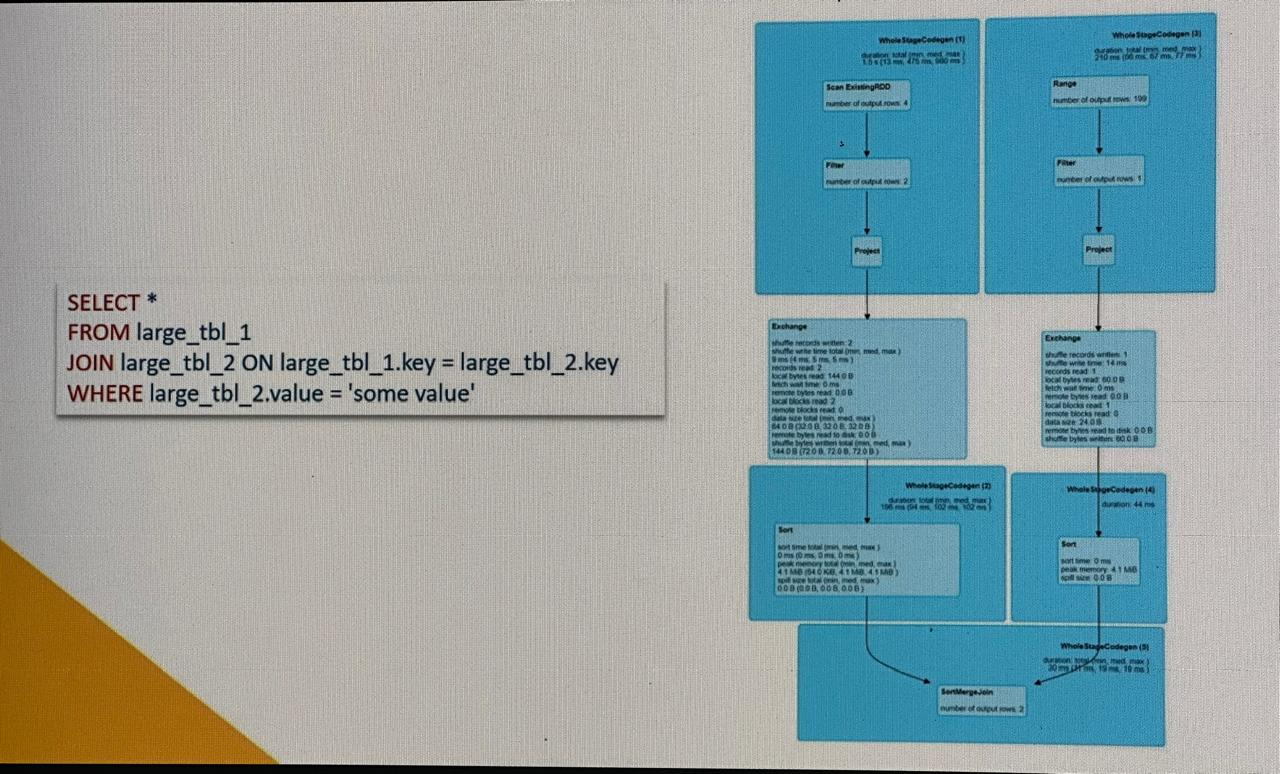

In [3]:
from IPython.display import Image
Image("/workspaces/Atlas/AtlasCodeLearn/ASonD/images/sort_merge_join.jpeg")

In [2]:
SELECT * FROM large_tbl_1 JOIN 
large_tbl_2 ON large_tbl_1.key=larget_tbl_2.key
WHERE larget_tbl_2.value='some_value'
OR
df1.join(df2, df1.key==df2.key, "inner").filter("value='some value'")

Both of tables are large tables, so we are expecting a "sort-merge" join to take place. In above plan we are reading two tables in 2 stages. Both these stages send data to exchange and everything after the exchange is part of the 3rd stage. 3rd stage collect data from the exchange, performs the sorting operation on the data and finally joins them.

fix here: Assuming both of tables are large enough, but we are also applying filter condition on the large_tbl_2(100GB tbl). And some analysis observed with filter only 7MB of data from the large table_2. Now large_tbl_1=100GB, selecting all rows from this table, large_tbl_2=100GB but selecting only 7 MB from that table. So we would like to apply here "Broadcast hash join" coz of my tables is small enough. It makes more sense to use broadast join and avoid the shuffle/sort operation. 

**Sort-merge to BroadCast Hash Join**  
But why it's not happening above?
- Spark will not apply Broadcast hash join if Broadcast Join Threshold is broken.
`spark.sql.autoBroadcastJoinThreshold=10MB` -> we are selecting 7MB from a large table, and that's below the default broadcast threshold. So it should apply but isn't coz Spark execution plan is created before the spark starts the job execution. Spark doesn't know the size of the table, so it applied a "sort-merge" join. So if I compute the statistics on the table, will spark apply the broadcast join? may or may not.
- Spark will not apply broadcast if don't have a column histogram for the filter column. cannot apply broadcast join if statistics are outdated.
- One solution is to analyze Spark tables and keep table and column statistics up to date.
- Another to enable AQE, as AQE computes statistics on the shuffle data and use to do the following things
    - We still have 3 stages in below plan, stage 1 & 2 are scanning data and sending data to exchange. But we enable AQE now
    - Adaptive Query will compute statistics on the exchange data. Statistics will tell that the size of larget_tbl_2 is small enough to apply broadcast join.
    - AQE will dynamically change the execution plan and apply broadcast hash join.
    - We still have shuffle as exchange in query plan, but we saved the sort operation. AQE can't avoid the shuffle coz it computes the statistics during the shuffle. But AQE will dynamically change the plan and apply broadcast hash join to save the expensive sort operation as shown in 2nd part of below image.
- But we still have a small problem-> Shuffle is already complete on large_tbl_2, we already distributed data from stage1 & stage2 to stage3 exchange. Now if we apply broadcast join sql/df, are we going to broadcast the table once again? Yes that is how broadcast works.
    - So AQE also gives us another configuration as shown in 3rd part of below image highlighed as yellow. The default value for this config is "True" `spark.sql.adaptive.localShuffleReader.enabled=true`. So if we manually don't set this to "False", optimized plan will look like 3rd part.
    - Both plans are almost same, but we have **Custom Shuffle Reader/Local Shuffle Reader** here in place of *BROADCAST ECHANGE*.
    - This Custom shuffle reader is specifically designed to further optimize the AQE broadcast join by reducing the network traffic. So while using AQE, don't disable localShuffleReader.

**Summary**
- Broadcast shuffle join is the most performant join strategy
- We can apply broadcast join if one side of the join can fit well in memory
- One table must be shorter than `spark.sql.autoBroadcastJoinThreshold`
- Estimating the table size is problematic in following scenarios
    - if applied a highly selective filter on the table
    - Join table is generated at runtime after a series of complex operations
- Spark AQE can help
    - AQE computes the table size at shuffle time
    - Replans the join strategy at runtime convering sort-merge join to a broadcast hash join

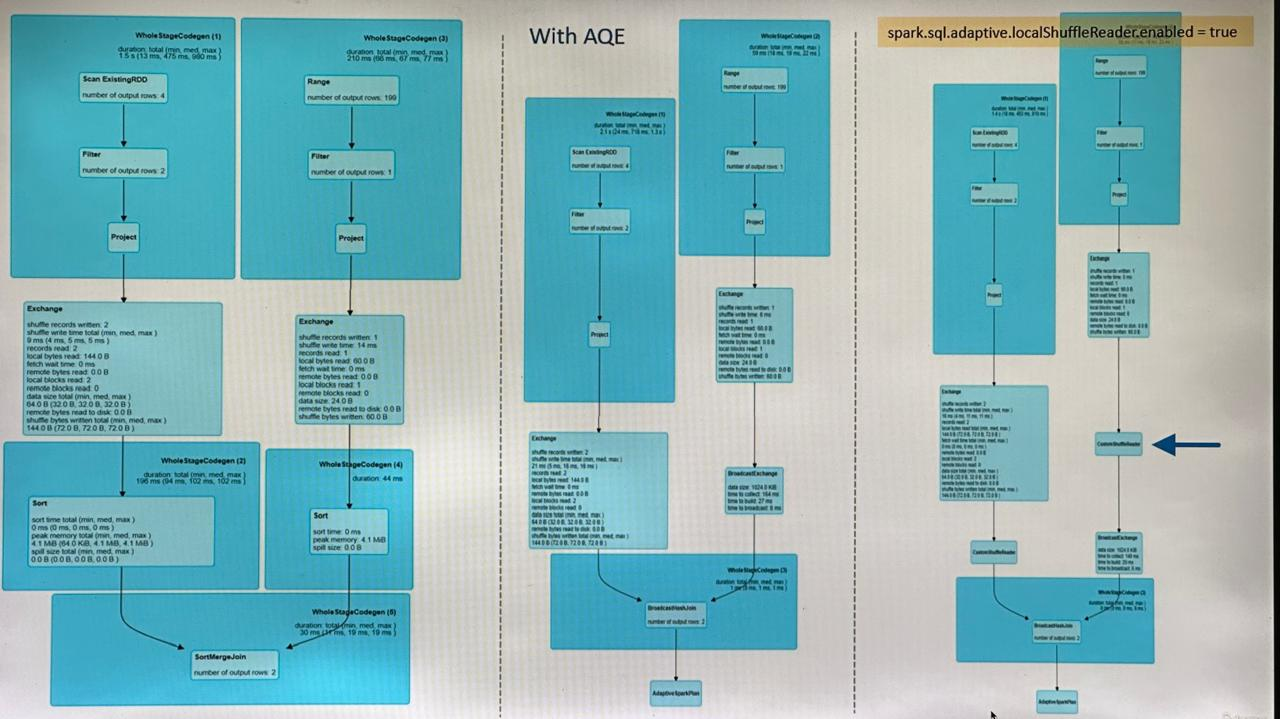

In [2]:
from IPython.display import Image
Image("/workspaces/Atlas/AtlasCodeLearn/ASonD/images/aqe_vs_noaqe.jpeg")

##### Dynamically optimizing skew joins/Handling Data Skew in Spark joins

**Problem**  - Why do we need dynamic join skew optimization?

`SELECT * FROM large_tbl_1 JOIN larget_tbl_2 ON large_tbl_1.key=large_tbl_2.key`
OR  
`df1.join(df2, df1.key == df2.key, "inner").filter("value=='some value'")`

Both tables are large and we are expecing "sort-merge" JOIN, and execution plan looks like-
<img src="/workspaces/Atlas/AtlasCodeLearn/ASonD/images/sort_merge_data_skew.jpeg">  
We have shuffle operation for both tables, that's why 2 exchanges here. The 1st exchange partitions the data by the join key for the 1st table, 2nd exchange partitioins the data by the join key for the 2nd table.

- Assume 1st table has 2 partitions, the primary purpose of the shuffle is to repartition the data by the key. Partitions for the 1st table are coming from the LEFT side, and the 2nd table comes from the RIGHT side. Spark appropriately partitioned the data by the key and assume those 5 unique keys are - UP, TS, TN, UK. Spark appropriately partitioned the data by these keys(states initials).
- Now all we need to to is sort each partition by the key and merge the records from both sides. We have 4 partitions to join so 4 tasks we need. Each task will pickup one color, sor the data and merge it to complete the join operation. *But the Green color partition(population of key=UP) is quite large on LEFT side*. This Green partition is <font color="Red">**Skewed**</font>. We need more memory to sort and merge the GREEN/UP partition. We planned 4 GB RAM for each, which would be sufficient for other tasks, but task working the GREEN color can't manage the sort/merge operation with 4GB RAM.
    - Can we increase Memory to handle the Skewed join?
        1. Memory wastage - can increase the memory assuming skewed partition, but not sure if all my joins will result in a skewed partition. We might have 10/15 join operations and all other join works well with 4GB RAM, however have 1 skewed join and it needs extra memory. Increasing memory for one specific join/task is not possible. *So we will end up increasing memory for entire application and that's wastage.*
        2. Not a permanent solution - coz data keeps changing, we might have a skewed partition today, which required 6GB to complete the sort/merge operation, but don't know what happens a week later. We get new data and skew is increased, now we need more memory ex- 8GB to pass through that skew. We can't let it fail every week/month and investigate logs and identify we need more memory coz data is now more skewed.
<img src="/workspaces/Atlas/AtlasCodeLearn/ASonD/images/skewed_partition.jpeg">

**Solution**  
Spark AQE offers skew optimization using the following configurations  
- `spark.sql.adaptive.enabled=true` : It enables the spark AQE feature
- `spark.sql.adaptive.skewJoin.enabled=true` : enables the skew-join optimization.
- After enabling above 2 config Spark AQE will detect this skewed partition, and it will do 2 things
    - Split the skewed partition on the LEFT side into 2/more partitions.
    - Duplicate the matching RIGHT-side partition.
    - Now we have 5 partitions, earlier we had 4, so now there would be 5 tasks and data partitions for all 5 tasks are almost the same, so they will consume uniform resources and finish simultaneously.  
    <img src="/workspaces/Atlas/AtlasCodeLearn/ASonD/images/fix_skewed_partition.jpeg">   
- We also have 2/more config to customize the Skew Join Optimization, these 2 config are used to define Skewness(When do we consider a partition as skewed partition and start splitting it?). Spark AQE assumes that the partition is skewed and starts splitting when both thresholds are broken.
    - `spark.sql.adaptive.skewJoin.skewedPartitionFactor=5` : default is 5, so a partitioin is considered skewed if its size is larger than 5 times the median partition size.
    - `spark.sql.adaptive.skewJoin.skewedPartitionThresholdInBytes=256MB` : default is 256MB, so a partition is considered skewed if its size in bytes is larger than this threshold.
    - <u>*But Spark AQE will initiate the split if only if both above thresholds are broken*</u>


#### Spark Dynamic Partition Pruning

Dynamic Partition Pruning a new feature available in Spark3.0 and above, and enabled by default. So we don't have to do anything to enable Spark Dynamic Partition Pruning.
`spark.sql.optimizer.dynamicPartitionPruning.enabled=true/false`  

Why do we need Dynamic Partition Pruning?
What is Dynamic Partition Pruning?

<u>Consider FACT table - Orders(partitioned by order_date)</u>  
`order_df = spark.read.parquet("orders)`  
`summary_df = order_df.where("order_date='2024-02-03').selectExpr("sum(unit_price*qty) as total_sales")`   
<img src="/workspaces/Atlas/AtlasCodeLearn/ASonD/images/predicate_pushdown.jpeg">  
- Physical Execution plan shows Spark performed 6 steps to complete this query. 1st step to scan/read the parquet file. Spark is doing a smart thing here.
- In the details of STEP 1: *PartitionFilters*, spark applied partition filters on the order_date column, and it is reading only 1 partition. Plan also shows number of files read 1.
- What is happening here? - in a typical case, Spark will read all the partitions of parquet data set and then apply the filter. But our table was partitioned on 'order_date' column. So spark decided to read only 1 partition that belongs to 3rd Feb 2024
- **Predicate Pushdown** means Spark will push down the WHERE clause filters down in the steps, and apply them as early as possible. Meaning Spark will not try typical sequence to read the data first, then filter and finally calculate the sums. Instead Spark will push the filter condition down to the Scan step and apply the where clause when reading the data itself.
    - Predicate Pushdown doesn't help much unless data is partitioned on the filter columns. Our Orders table is already partitioned on order_date column, so spark decided to read only 1 partition for 3rd Feb 2024, and it can simply leave all other partitions, and this feature is known as **Partition Pruning**.
- These 2 features optimize query and reduce the read volume of data.

**Dynamic Partition Pruning**  
<u>Consider 2 tables, FACT table - Orders(partitioned by order_date) & DIMENSION table - Dates </u>  

`SELECT year, month, sum(unit_price*qty) as total_sales FROM orders JOIN dates ON order_date=full_date GROUP BY year,month WHERE year='2024' AND month='02'`  
OR  
`join_expr=order_df.order_date == date_df.full_date`  
`order_df.join(date_df, join_expr, "inner").filter("year==2024 and month==2").groupBy("year","month").agg(f.sum(f.expr("unit_price*qty")).alias("total_sales))`

<u>*Problem*</u>  
When Dynamic Partition Pruning is Disabled Manually to show diff: will yeild sort/merge join execution plan, Orders table is partitioned on the order_date column, but it doesn't benefit here. in the SCAN parquet step number of files read is 4. Physical plan shows the partition filter step, but it is not pruning any partitions coz we don't have any filter condition on order_date. We are filtering on year & month columns on the DATES table, and want to read only Feb-2024 partition but Spark is reading other month partitions also. Best case to read only Feb-2024 partition and leave rest of the partition. It is not applying partition pruning coz filters are on dates not on Orders table.
<img src="/workspaces/Atlas/AtlasCodeLearn/ASonD/images/disabled_partition_pruning.jpeg">  

<u>*Fix*</u>  
- Enable Dynamic Partition Pruning feature : enabled by default on Spark3.0
- Apply Broadcast on the dimension table : f.broadcast(date_df)  
`join_expr=order_df.order_date == date_df.full_date`  
`order_df.join(f.broadcast(date_df), join_expr, "inner").filter("year==2024 and month==2").groupBy("year","month").agg(f.sum(f.expr("unit_price*qty")).alias("total_sales))`  
- Now dates_df is going for a broadcast exchange. But then Spark creates a subquery from the broadcasted dates_df and sedning it as an input to the parquet scan, and now the number of files read is 2. Spark applied partition pruning, and now it is reading only Feb-2024 partitions.
- In the physical plan: scan parquet details - 'dynamic pruning expression' we can see.
- Spark Dynamic partition pruning can take a filter condition from our dimesion table and inject it into fact table as a subquery. Once a subquery is injected into fact table, Spark can apply partition pruning on fact table.
- To use this feature:
    - Works for fact & dimension like tables
    - Fact table must be partitioned
    - Broadcast dimension table : if smaller than 10MB spark will automatically broadcast, but we should broadcast anyway.

<img src="/workspaces/Atlas/AtlasCodeLearn/ASonD/images/dpp_enabled.jpeg">  

#### Data Caching in Spark